# Objectifs : 
1. récupérer les données de la profondeur de marché d'une paire (PAIR) sur l'exchange binance
2. récupérer l'historique de prix de cette pair sur une période donné (PERIODE)
3. Tracer sur un meme graphique ces deux données  

In [40]:
# Libraries 
from binance.client import Client
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [41]:
# Connect to binance API
INPUT_FILE= "API_KEYS.txt"

with open(INPUT_FILE, 'r', encoding='utf-8') as file:
    contenu_liste = file.read()

KEYS = contenu_liste.split(',')
KEYS = [element.strip() for element in KEYS]

api_key = KEYS[0]
api_secret = KEYS[1]
client = Client(api_key,api_secret)

In [42]:
# Initialiser les constantes 
PAIR = "BTCUSDT"
PERIODE = 720 # 30*24

In [43]:
# Récupération de la profondeur de marché actuelle
market_depth = client.get_order_book(symbol=PAIR)

# Ranger les bids et les asks dans deux dataframes
bids = pd.DataFrame(market_depth['bids'], columns=['price', 'bids'])
asks = pd.DataFrame(market_depth['asks'], columns=['price', 'asks'])

# Conversion en float
bids['price'] = bids['price'].astype(float)
bids['bids'] = bids['bids'].astype(float)
asks['price'] = asks['price'].astype(float)
asks['asks'] = asks['asks'].astype(float)

# Ajouter une colonne de somme cumulée 
bids['bids_cumsum'] = bids['bids'].cumsum()
asks['asks_cumsum'] = asks['asks'].cumsum()

# Recherche du min des bids / max des asks qui est l'interface offre/demande 
min_price = min(bids['price'])
max_price = max(asks['price'])

In [44]:
# Récupérer le prix journalier d'une paire sur une période donnée
# Définition de l'intervalle 
interval = Client.KLINE_INTERVAL_1HOUR

# Récupération des données de prix journaliers
candlesticks = client.get_klines(symbol=PAIR, interval=interval, limit=PERIODE)

# Transformation des données en DataFrame pour une meilleure lisibilité
columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
           'Close Time', 'Quote Asset Volume', 'Number of Trades', 
           'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore']

df_pair = pd.DataFrame(candlesticks, columns=columns)

# Conversion des timestamps pour une meilleure lisibilité
df_pair['Open Time'] = pd.to_datetime(df_pair['Open Time'], unit='ms')
df_pair['Close Time'] = pd.to_datetime(df_pair['Close Time'], unit='ms')
# Conversion en float
df_pair['Close'] = df_pair['Close'].astype(float)

# # Filtrer les colonnes importantes
# df_pair = df_pair[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Affichage des données
print(df_pair)

              Open Time            Open            High             Low  \
0   2024-11-27 23:00:00  96047.47000000  96183.01000000  95731.72000000   
1   2024-11-28 00:00:00  95863.11000000  96564.00000000  95722.22000000   
2   2024-11-28 01:00:00  96552.00000000  96552.52000000  96084.00000000   
3   2024-11-28 02:00:00  96273.94000000  96439.69000000  95624.01000000   
4   2024-11-28 03:00:00  95699.79000000  95789.33000000  94822.54000000   
..                  ...             ...             ...             ...   
715 2024-12-27 18:00:00  94291.30000000  94770.15000000  94212.30000000   
716 2024-12-27 19:00:00  94566.05000000  94810.07000000  94252.00000000   
717 2024-12-27 20:00:00  94750.11000000  94778.43000000  94313.82000000   
718 2024-12-27 21:00:00  94588.12000000  94823.09000000  94379.35000000   
719 2024-12-27 22:00:00  94526.07000000  94625.99000000  94200.00000000   

        Close         Volume              Close Time  Quote Asset Volume  \
0    95863.11  1783.778

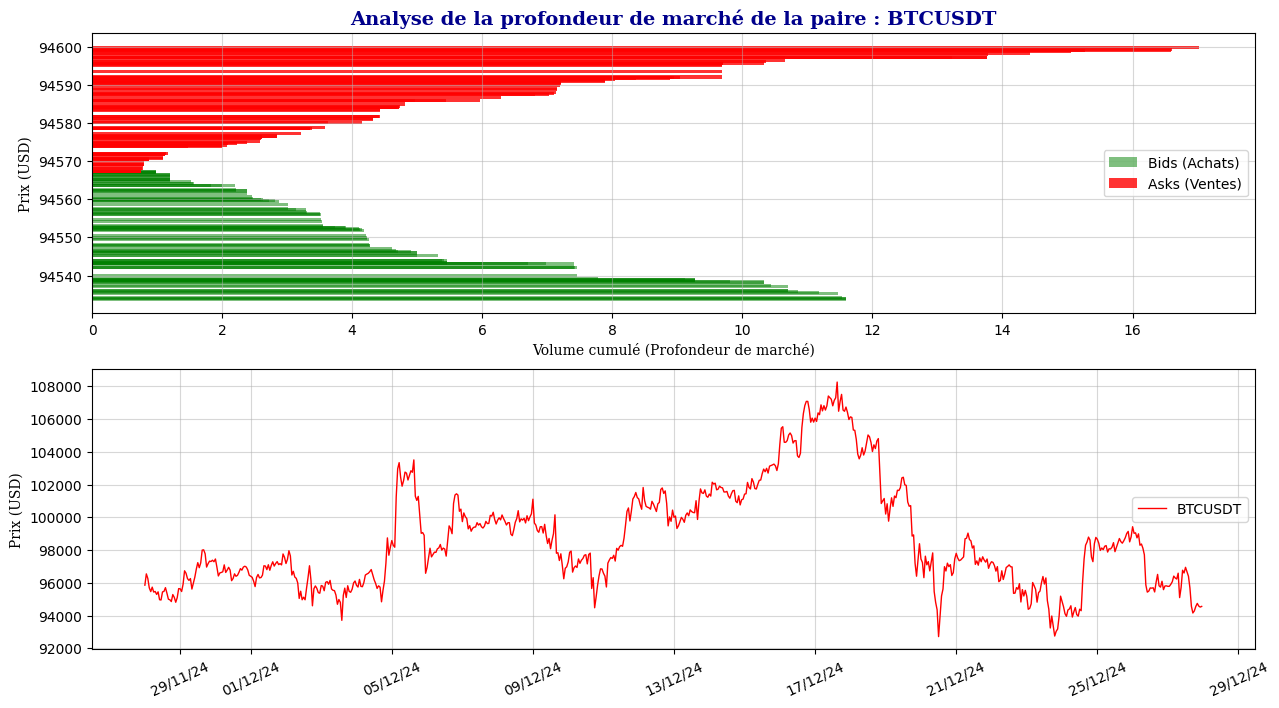

In [45]:
## GRAPHIQUE SIMPLE
TITLE = "Analyse de la profondeur de marché de la paire : {paire}".format(paire=PAIR) # Titre de la figure

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.2)

# Format date xaxis
myFmt = mdates.DateFormatter('%d/%m/%y')
axes[1].xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=25)
# plt.tight_layout()

# Zone 1
axes[0].set_title(TITLE, fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes[0].barh(bids['price'], bids['bids_cumsum'], color='green', alpha=0.5, label='Bids (Achats)')
axes[0].barh(asks['price'], asks['asks_cumsum'], color='red', alpha=0.8, label='Asks (Ventes)')
axes[0].set_ylabel("Prix (USD)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[0].set_xlabel("Volume cumulé (Profondeur de marché)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[0].grid(True, alpha=0.5)
axes[0].xaxis.set_visible(True)
axes[0].legend(loc="center right")

# Zone 2
axes[1].plot(df_pair['Close Time'],df_pair['Close'],'r',linewidth=1,label=PAIR)
axes[1].set_ylabel("Prix (USD)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[1].grid(True, alpha=0.5)
axes[1].legend(loc="center right")
# axes[1].xaxis.set_visible(False)
